# 03-3 사전 훈련된 모델을 새로운 문제에 적용하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/03-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 텐서플로 허브로 강아지 사진 분류하기

In [1]:
import tf_keras as keras
from tf_keras import layers
import tensorflow_hub as hub

In [2]:
hub_efficientb0 = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1.0 / 255.0),
    hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1")
])

In [3]:
!gdown 1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
!unzip cat-dog-images.zip

Downloading...
From: https://drive.google.com/uc?id=1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
To: /content/cat-dog-images.zip
100% 182k/182k [00:00<00:00, 95.8MB/s]
Archive:  cat-dog-images.zip
   creating: images/
  inflating: images/dog.png          
  inflating: images/cat.png          


In [4]:
import numpy as np
from PIL import Image

dog_png = np.array(Image.open('images/dog.png'))

In [5]:
from keras.applications import efficientnet

predictions = hub_efficientb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n02099712', 'Labrador_retriever', np.float32(0.3682942)),
  ('n02104029', 'kuvasz', np.float32(0.19339868)),
  ('n02099601', 'golden_retriever', np.float32(0.061458193)),
  ('n02111500', 'Great_Pyrenees', np.float32(0.05779694)),
  ('n02095889', 'Sealyham_terrier', np.float32(0.017902788))]]

## 허깅페이스로 강아지 사진 분류하기

In [6]:
from transformers import pipeline

pipe = pipeline(task='image-classification', device=0,
                model='google/efficientnet-b0')
pipe('images/dog.png')

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

[{'label': 'Labrador retriever', 'score': 0.36829379200935364},
 {'label': 'kuvasz', 'score': 0.19339875876903534},
 {'label': 'golden retriever', 'score': 0.06145830079913139},
 {'label': 'Great Pyrenees', 'score': 0.057797010987997055},
 {'label': 'Sealyham terrier, Sealyham', 'score': 0.01790277287364006}]

## 전이 학습으로 피스타치오 품종 분류하기

### 사전 훈련된 모델로 피스타치오 품종 분류하기

In [7]:
!gdown 10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo
!unzip -q Pistachio_Image_Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo
To: /content/Pistachio_Image_Dataset.zip
100% 25.9M/25.9M [00:00<00:00, 34.4MB/s]


In [8]:
pistachio_sample = np.array(Image.open('Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg'))
pistachio_sample.shape

(600, 600, 3)

In [9]:
efficientb7 = keras.applications.EfficientNetB7()
predictions = efficientb7.predict(pistachio_sample[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 7s 7s/step


[[('n01950731', 'sea_slug', np.float32(0.23482428)),
  ('n01924916', 'flatworm', np.float32(0.20674421)),
  ('n01943899', 'conch', np.float32(0.08622336)),
  ('n01945685', 'slug', np.float32(0.08500543)),
  ('n01955084', 'chiton', np.float32(0.02824293))]]

### 전이 학습으로 피스타치오 품종 분류하기

In [10]:
keras_efficientb0_base = keras.applications.EfficientNetB0(include_top=False)
feature_map = keras_efficientb0_base(pistachio_sample[np.newaxis,:])
feature_map.shape

16705208/16705208 [==============================] - 1s 0us/step


TensorShape([1, 18, 18, 1280])

In [11]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'Pistachio_Image_Dataset', image_size=(224, 224), batch_size=16,
    validation_split=0.2, subset='both', seed=42
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


In [12]:
keras_efficientb0_base.trainable = False

In [13]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras_efficientb0_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [14]:
rmsprop = keras.optimizers.RMSprop(learning_rate=5e-5)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 18s 91ms/step - loss: 0.4898 - accuracy: 0.8173 - val_loss: 0.3589 - val_accuracy: 0.9091
Epoch 2/20
108/108 [==============================] - 5s 46ms/step - loss: 0.3160 - accuracy: 0.9110 - val_loss: 0.2491 - val_accuracy: 0.9301
Epoch 3/20
108/108 [==============================] - 5s 41ms/step - loss: 0.2351 - accuracy: 0.9290 - val_loss: 0.1937 - val_accuracy: 0.9487
Epoch 4/20
108/108 [==============================] - 5s 47ms/step - loss: 0.1920 - accuracy: 0.9476 - val_loss: 0.1634 - val_accuracy: 0.9464
Epoch 5/20
108/108 [==============================] - 5s 41ms/step - loss: 0.1619 - accuracy: 0.9506 - val_loss: 0.1396 - val_accuracy: 0.9604
Epoch 6/20
108/108 [==============================] - 5s 41ms/step - loss: 0.1359 - accuracy: 0.9622 - val_loss: 0.1233 - val_accuracy: 0.9650
Epoch 7/20
108/108 [==============================] - 5s 48ms/step - loss: 0.1262 - accuracy: 0.9645 - val_loss: 0.1135 - val_accuracy: 0.969

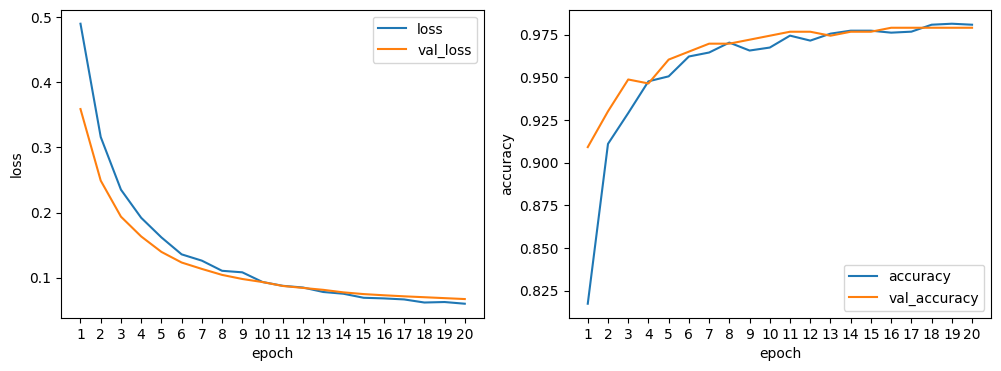

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

## 미니 프로젝트

In [16]:
kaggle_efficientb0_base = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1')

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1.0 / 255.0)(inputs)
x = kaggle_efficientb0_base(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [17]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 16s 52ms/step - loss: 0.4000 - accuracy: 0.8534 - val_loss: 0.2474 - val_accuracy: 0.9277
Epoch 2/20
108/108 [==============================] - 5s 42ms/step - loss: 0.2003 - accuracy: 0.9459 - val_loss: 0.1597 - val_accuracy: 0.9604
Epoch 3/20
108/108 [==============================] - 5s 42ms/step - loss: 0.1402 - accuracy: 0.9628 - val_loss: 0.1271 - val_accuracy: 0.9650
Epoch 4/20
108/108 [==============================] - 4s 39ms/step - loss: 0.1098 - accuracy: 0.9697 - val_loss: 0.1234 - val_accuracy: 0.9604
Epoch 5/20
108/108 [==============================] - 5s 46ms/step - loss: 0.0913 - accuracy: 0.9727 - val_loss: 0.1035 - val_accuracy: 0.9650
Epoch 6/20
108/108 [==============================] - 4s 40ms/step - loss: 0.0776 - accuracy: 0.9791 - val_loss: 0.0906 - val_accuracy: 0.9744
Epoch 7/20
108/108 [==============================] - 4s 39ms/step - loss: 0.0684 - accuracy: 0.9808 - val_loss: 0.0803 - val_accuracy: 0.976

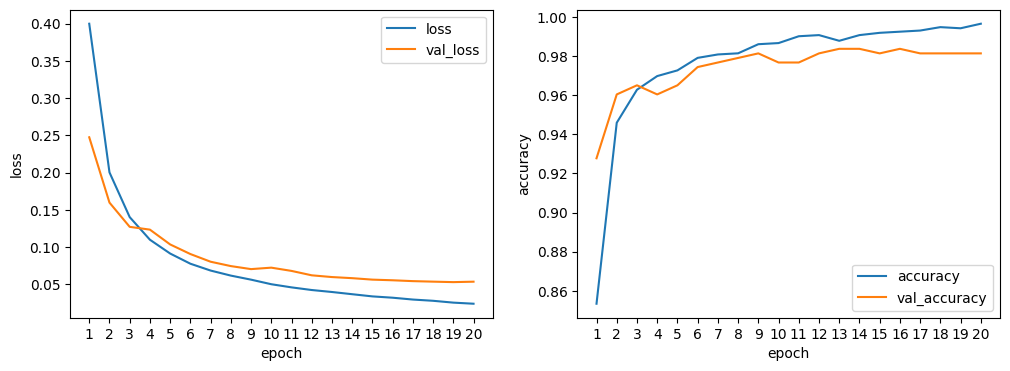

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()